In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import pandas as pd
import os
from time import sleep
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('whitegrid')
import re

## Create driver

In [29]:
chrome_options = Options()
#chrome_options.add_argument('--headless')
chrome_options.add_argument('--window-size=1920x1080')
driver = webdriver.Chrome(options=chrome_options)


## Go to oddschecker website

In [3]:
url = 'https://www.oddschecker.com/football/football-specials'
driver.get(url)

## Sometimes there is annoying popup

In [4]:
try:
    driver.find_element_by_xpath('//*[@id="promo-modal"]/div[1]/div/div/div[5]/a').click()
except:
    print('no popup')
sleep(1)

## Find the transfer rumours


In [5]:
fixtures = driver.find_element_by_xpath('//*[@id="outrights"]/div/ul')
markets = fixtures.find_elements_by_tag_name('li')
links = [m.find_element_by_tag_name('a').get_attribute('href') for m in markets]
transfer_links = [l for l in links if  'club-after-summer-transfer-window' in l]

## Helper method for parsing odds string (including fractions)

In [7]:
def parse_odds(x):
    x_str = str(x)
    if '/' in x_str:
        num, denom = x_str.split('/')
        return int(num) / int(denom)
    else:
        try:
            return int(x)
        except:
            return np.nan

## Scrape all transfer rumours

In [8]:
combined_df = pd.DataFrame()

In [9]:
for i, l in enumerate(transfer_links):
    print(l, end="")
    print()
    print(f'{i}/{len(transfer_links)}')
    print()
    sleep(1)
    driver.get(l)
    tables = pd.read_html(driver.page_source)
    # Odds table seems to be last table on page
    odds_df = tables[-1]
    # Remove crazy long column names
    odds_df.columns = [''] * len(odds_df.columns)
    # Transpose - clubs along axis
    clean_df = odds_df.T.rename(columns=odds_df.T.iloc[0])
    # Calculate lowest odds - most likely
    long_df = pd.DataFrame(clean_df.applymap(parse_odds).min()).reset_index()
    # Add in column names, including player name
    long_df.columns = ['destination', 'odds']
    long_df['player'] = l.split('/')[-2].replace('-',' ').title()
    # Append to df
    combined_df = combined_df.append(long_df,sort=False)

https://www.oddschecker.com/football/player-specials/sadio-mane/club-after-summer-transfer-window

0/79

https://www.oddschecker.com/football/player-specials/aaron-mooy/club-after-summer-transfer-window

1/79

https://www.oddschecker.com/football/player-specials/aaron-wan-bissaka/club-after-summer-transfer-window

2/79

https://www.oddschecker.com/football/player-specials/adrian-rabiot/club-after-summer-transfer-window

3/79

https://www.oddschecker.com/football/player-specials/aleksandar-mitrovic/club-after-summer-transfer-window

4/79

https://www.oddschecker.com/football/player-specials/alex-telles/club-after-summer-transfer-window

5/79

https://www.oddschecker.com/football/player-specials/alexis-sanchez/club-after-summer-transfer-window

6/79

https://www.oddschecker.com/football/player-specials/alfredo-morelos/club-after-summer-transfer-window

7/79

https://www.oddschecker.com/football/player-specials/antoine-griezmann/club-after-summer-transfer-window

8/79

https://www.oddsche

In [10]:
combined_df['probability'] = 1 / (1 + combined_df['odds'])

## Plotting functions, by club and by player

In [65]:
def get_player_destinations(df,player):
    club_df = df.loc[(df.player==player) &
                             (df.probability > 0)].sort_values(by='probability',ascending=False)
    
    plt.subplots(figsize=(20,15))
    ax = sns.barplot(data=club_df,y='destination',x='probability',orient='h')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    ax.set_title(f'{player} Destinations \n',{'fontsize':20})
    plt.savefig(f'output/players/{player}.png')

In [66]:
def get_club_targets(df,club):
    club_df = df.loc[(df.destination==club) &
                             (df.probability > 0)].sort_values(by='probability',ascending=False)
    plt.subplots(figsize=(20,15))
    ax = sns.barplot(data=club_df,y='player',x='probability',orient='h')
    ax.set_title(f'{club} Transfer Targets \n',{'fontsize':20})
    plt.savefig(f'output/clubs/{club}.png')

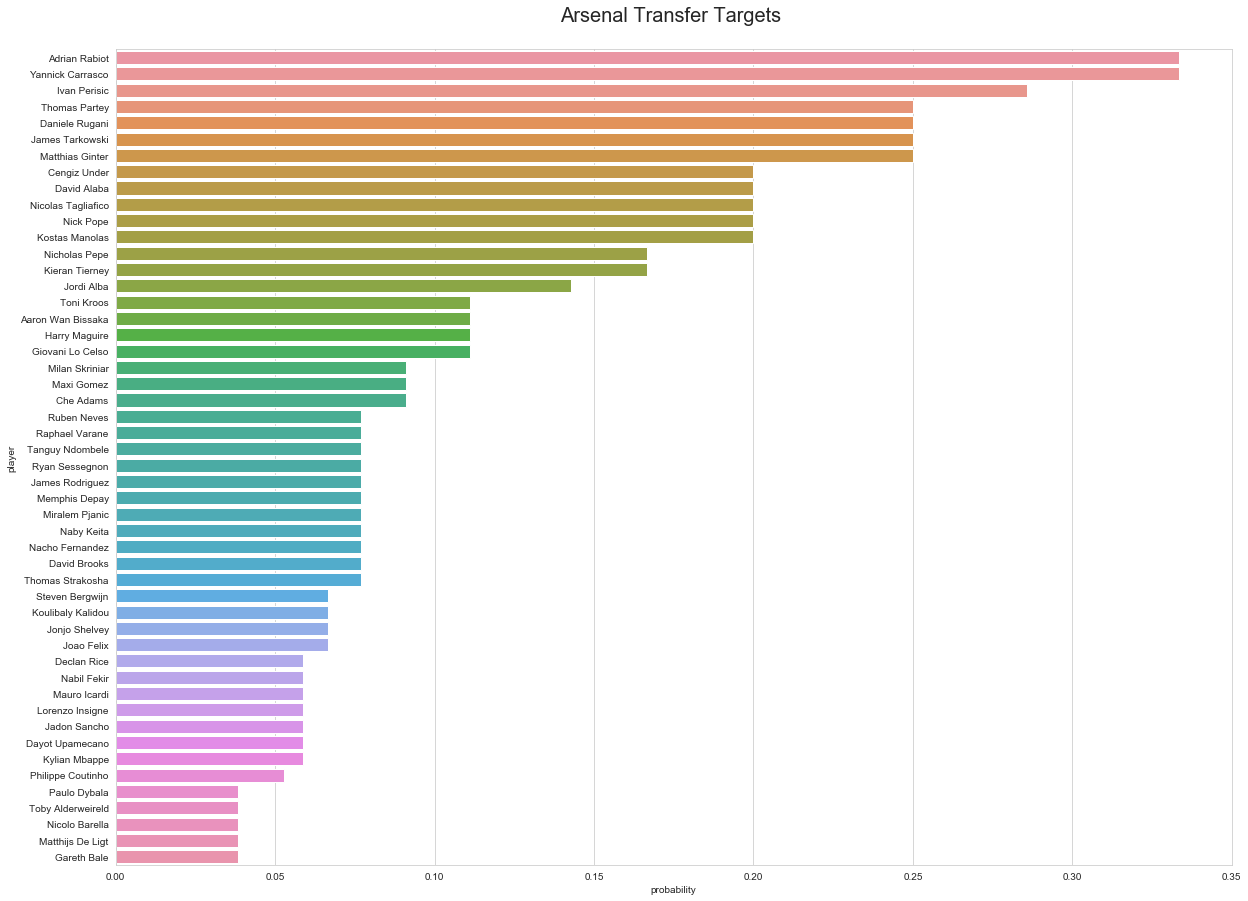

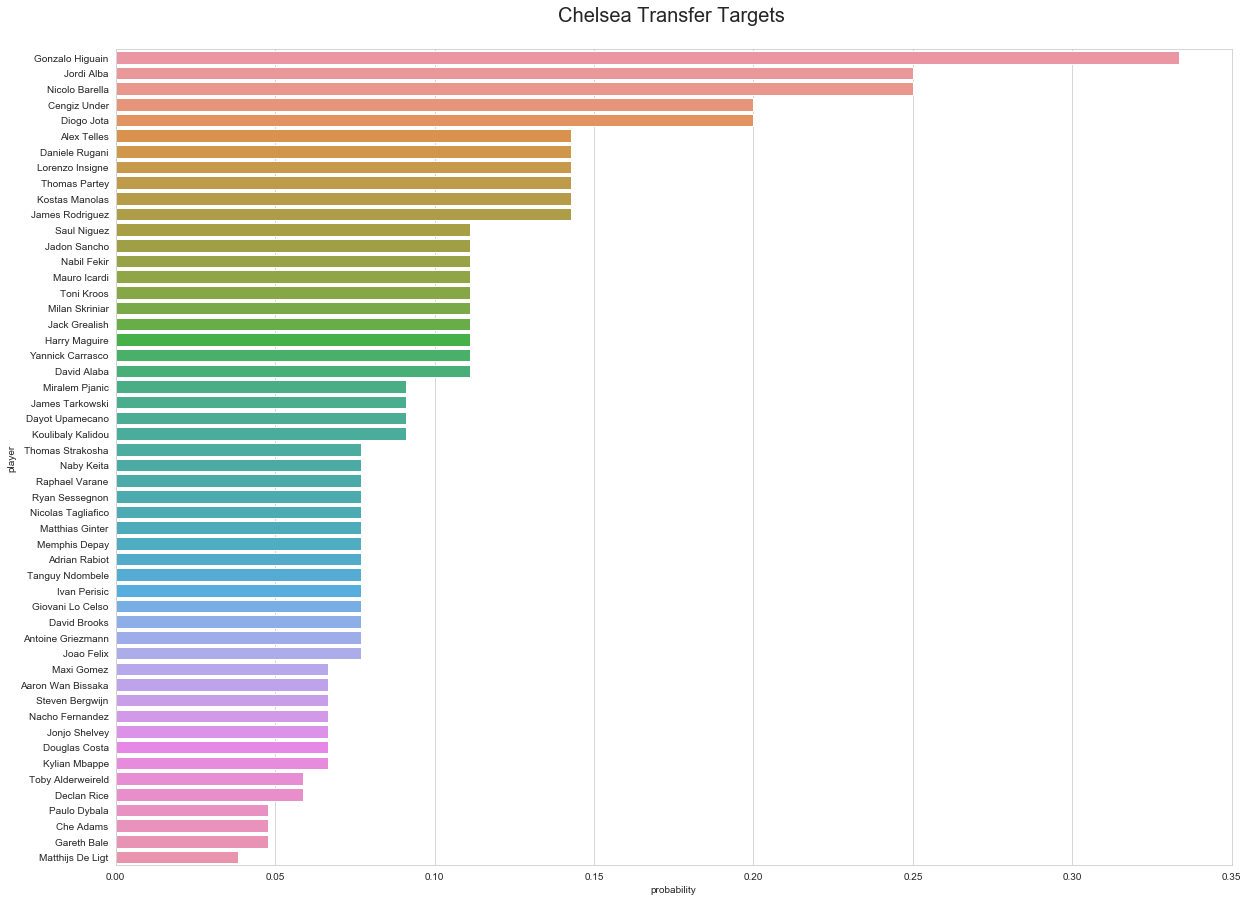

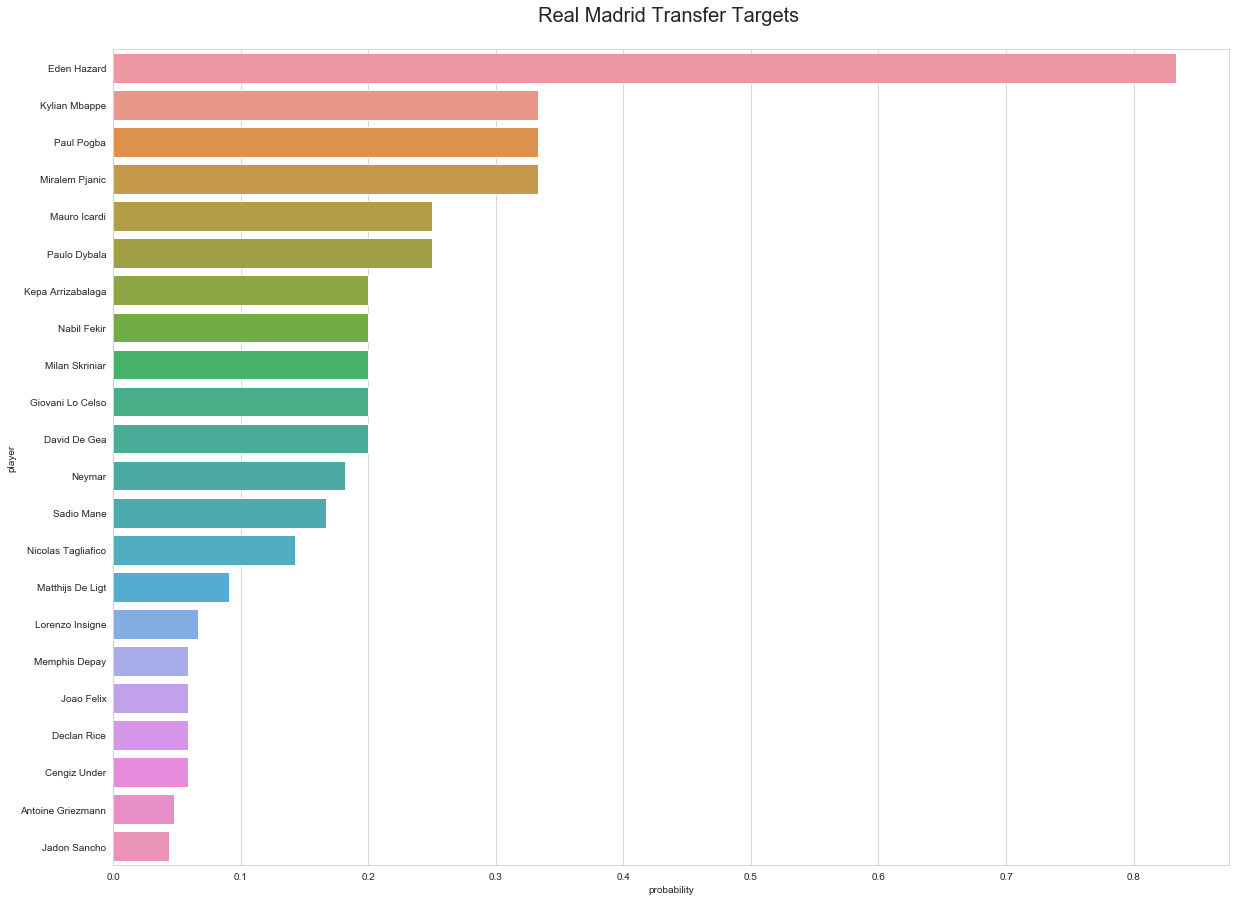

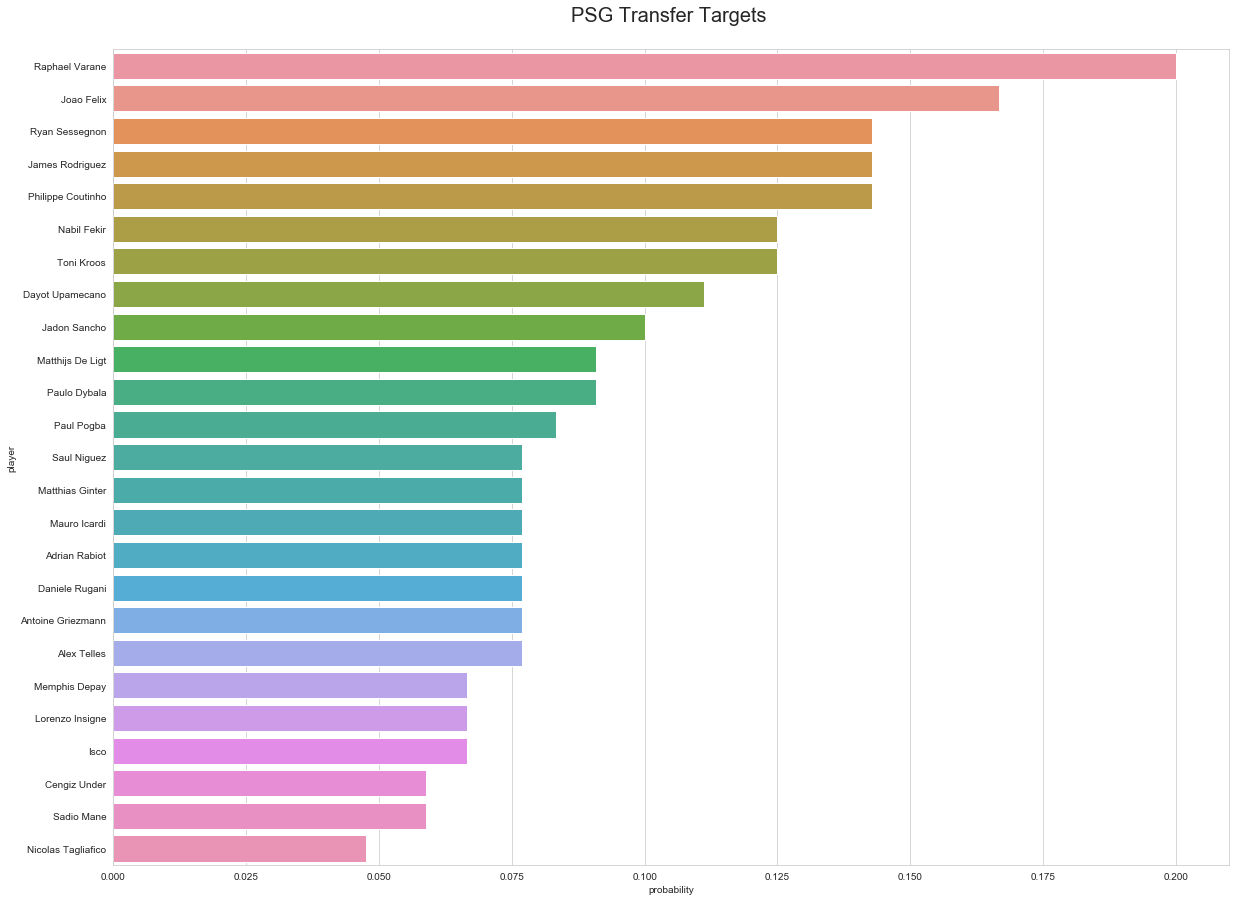

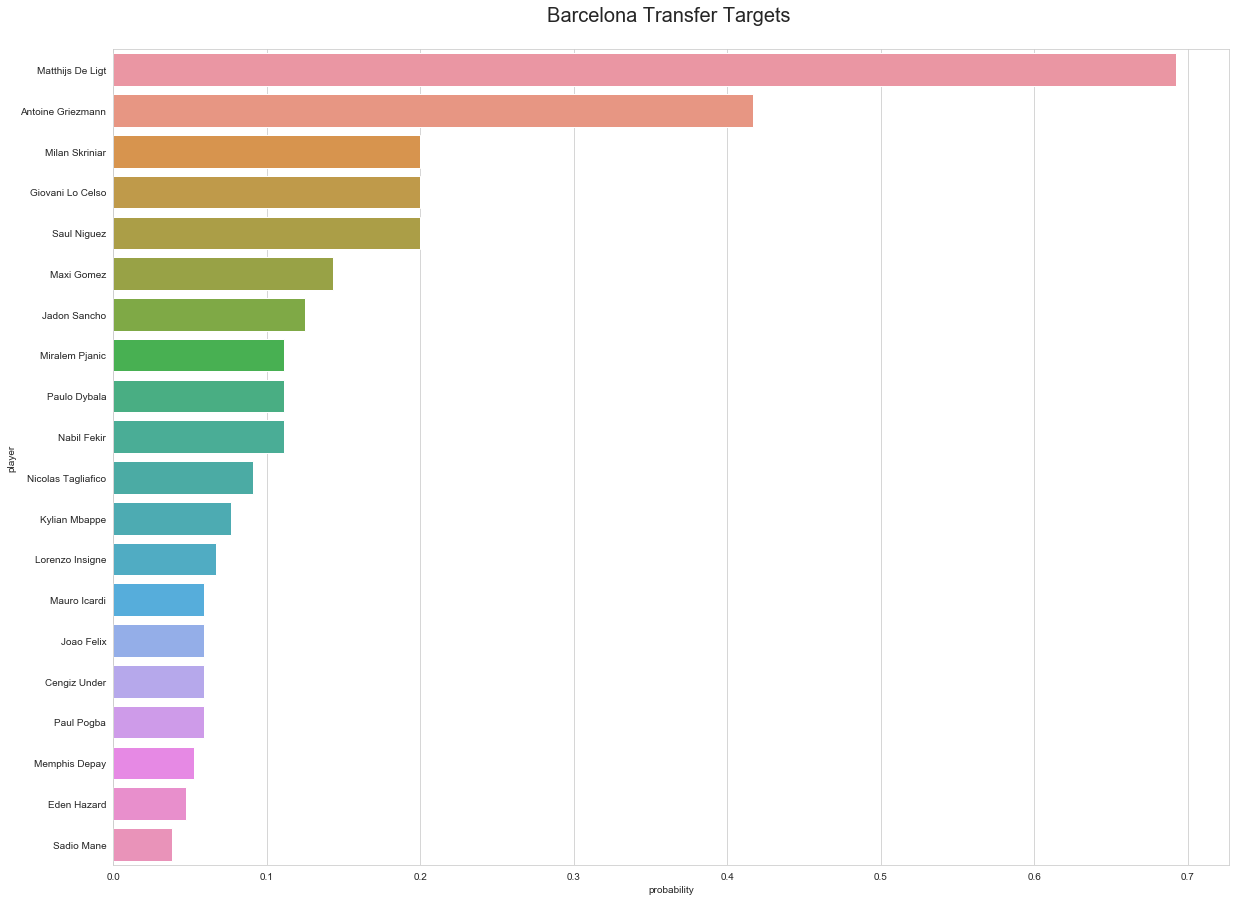

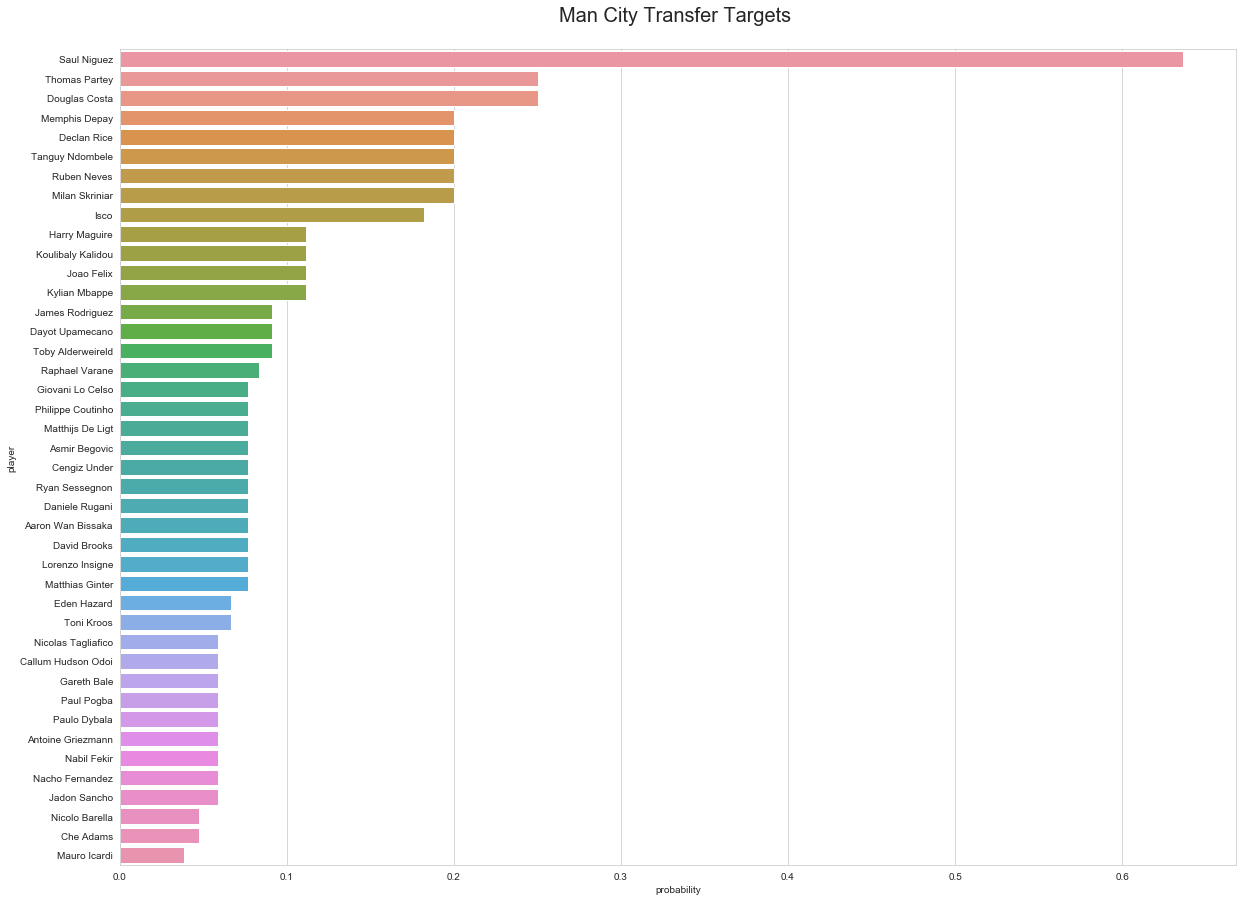

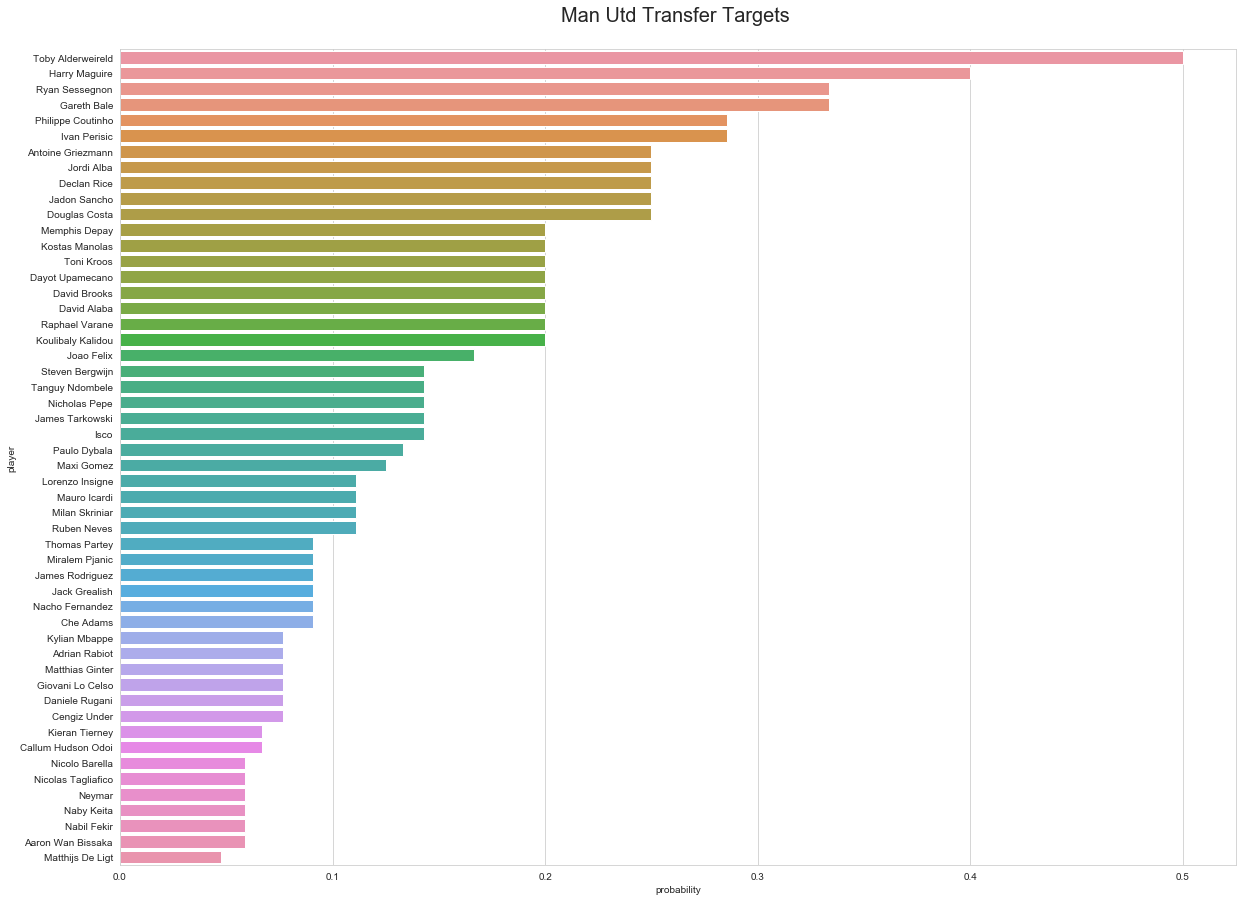

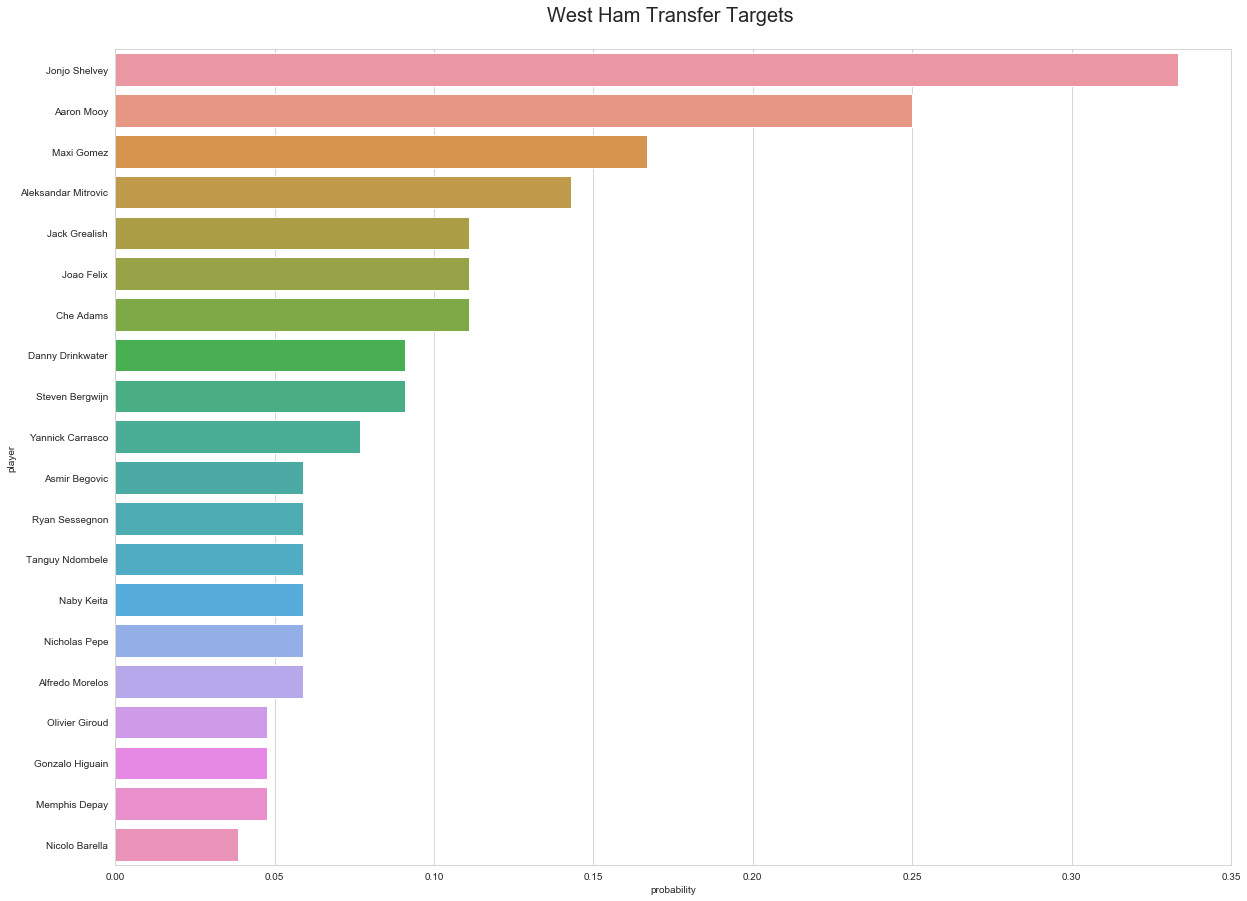

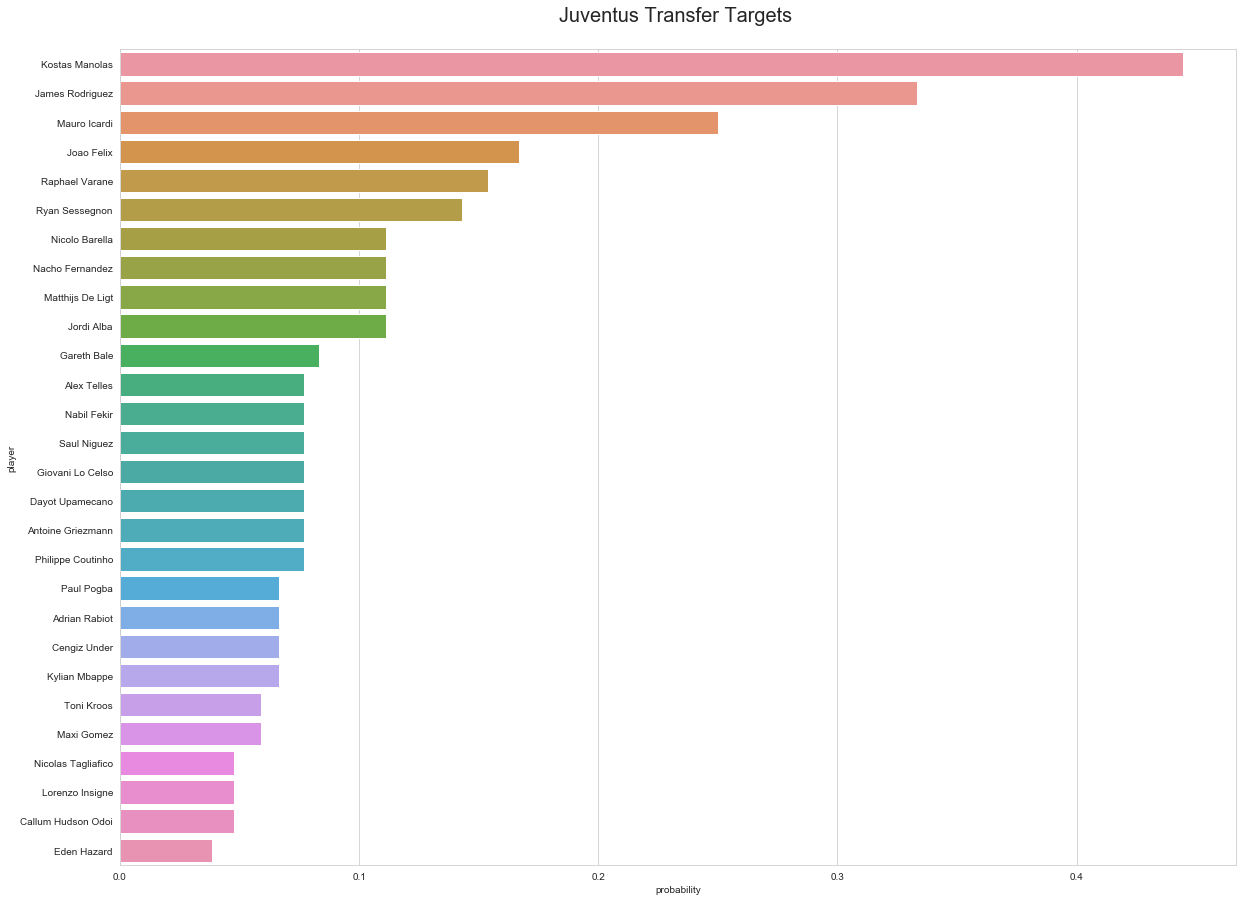

In [67]:
for club in ['Arsenal','Chelsea','Real Madrid', 'PSG', 'Barcelona','Man City','Man Utd','West Ham','Juventus']:
    get_club_targets(combined_df,club)

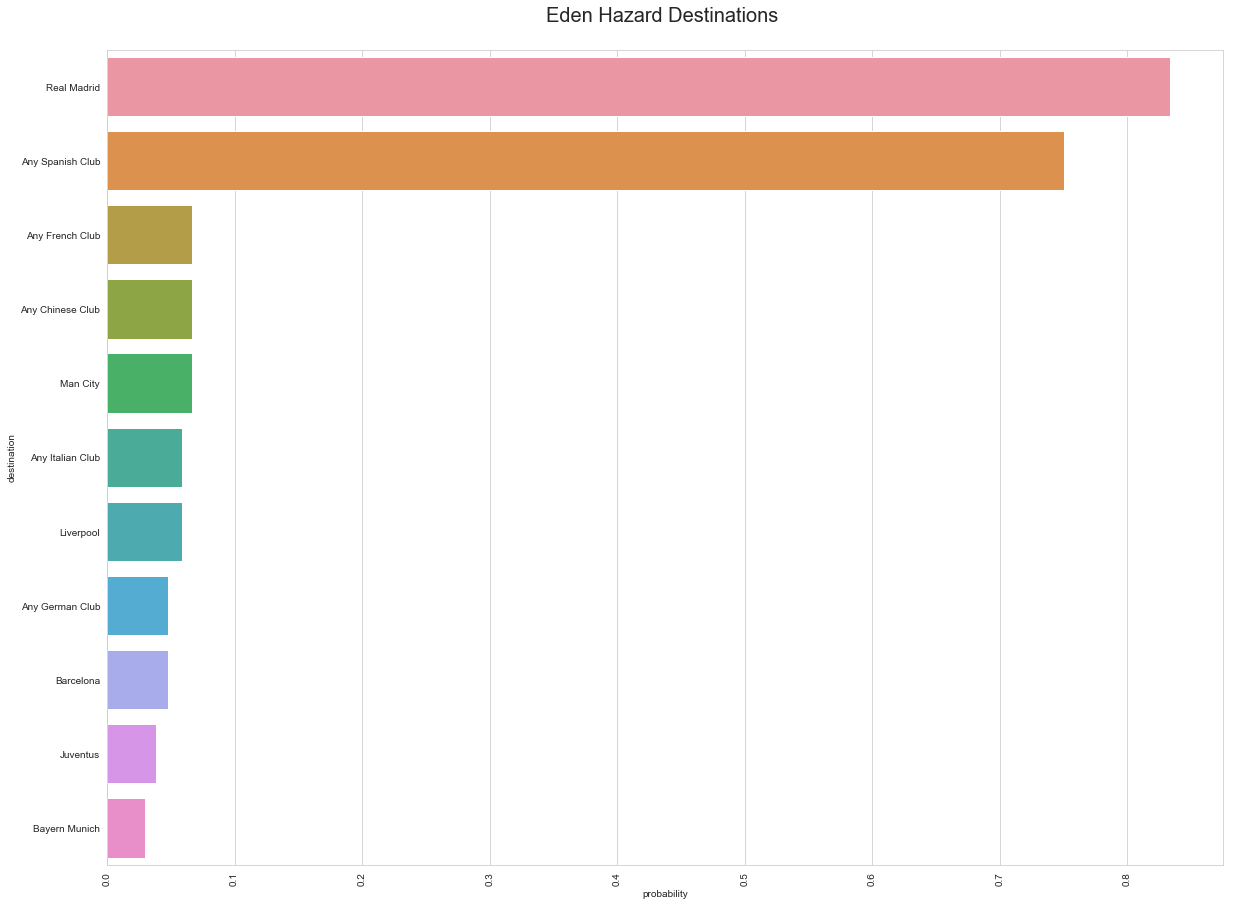

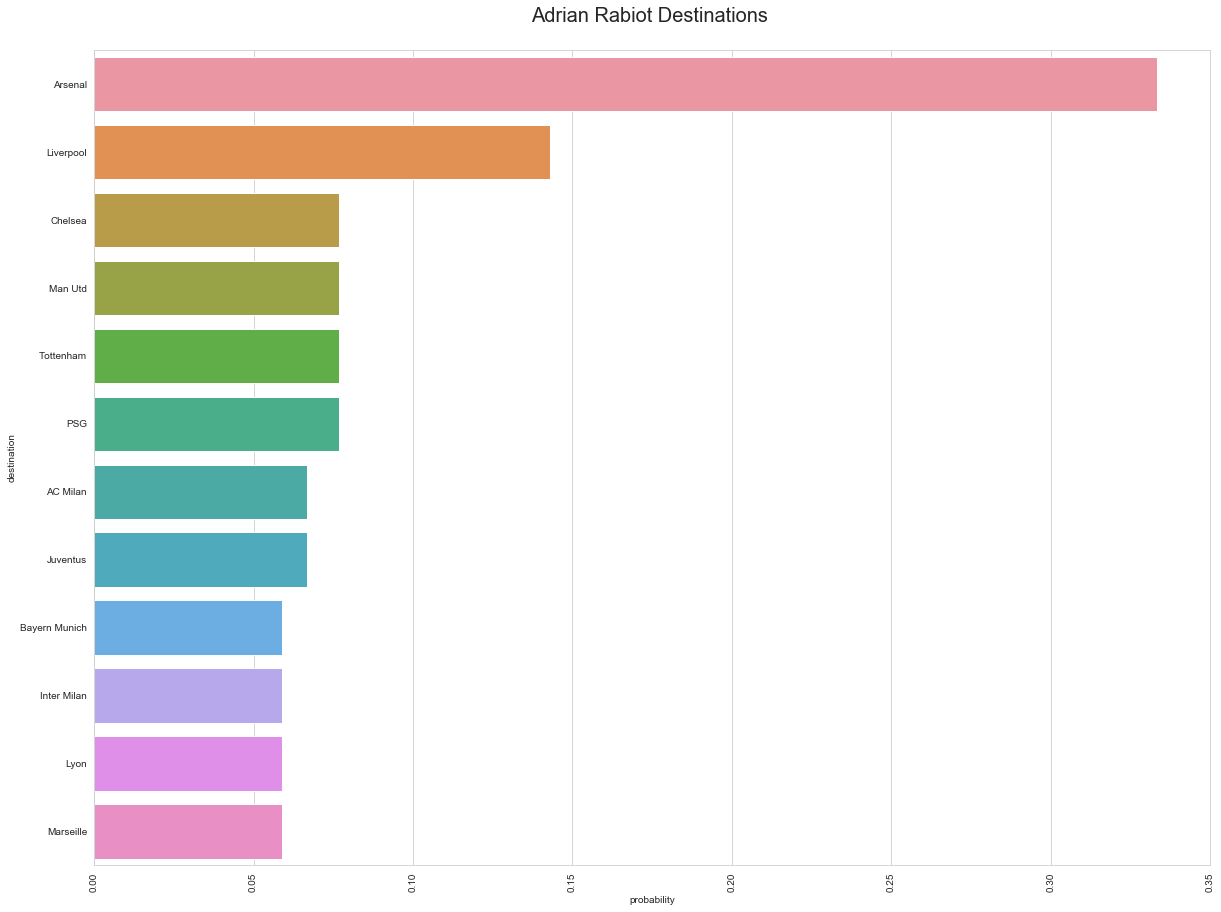

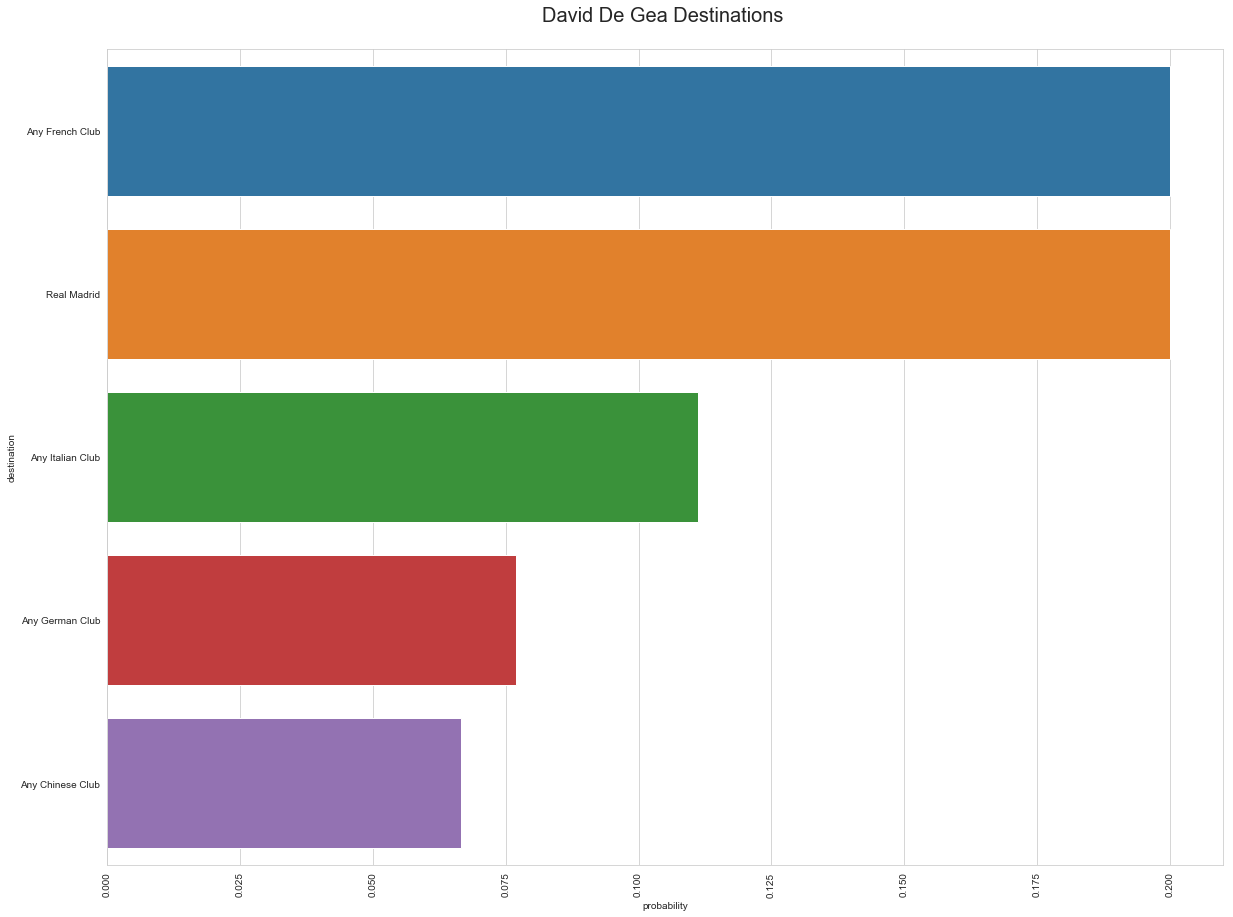

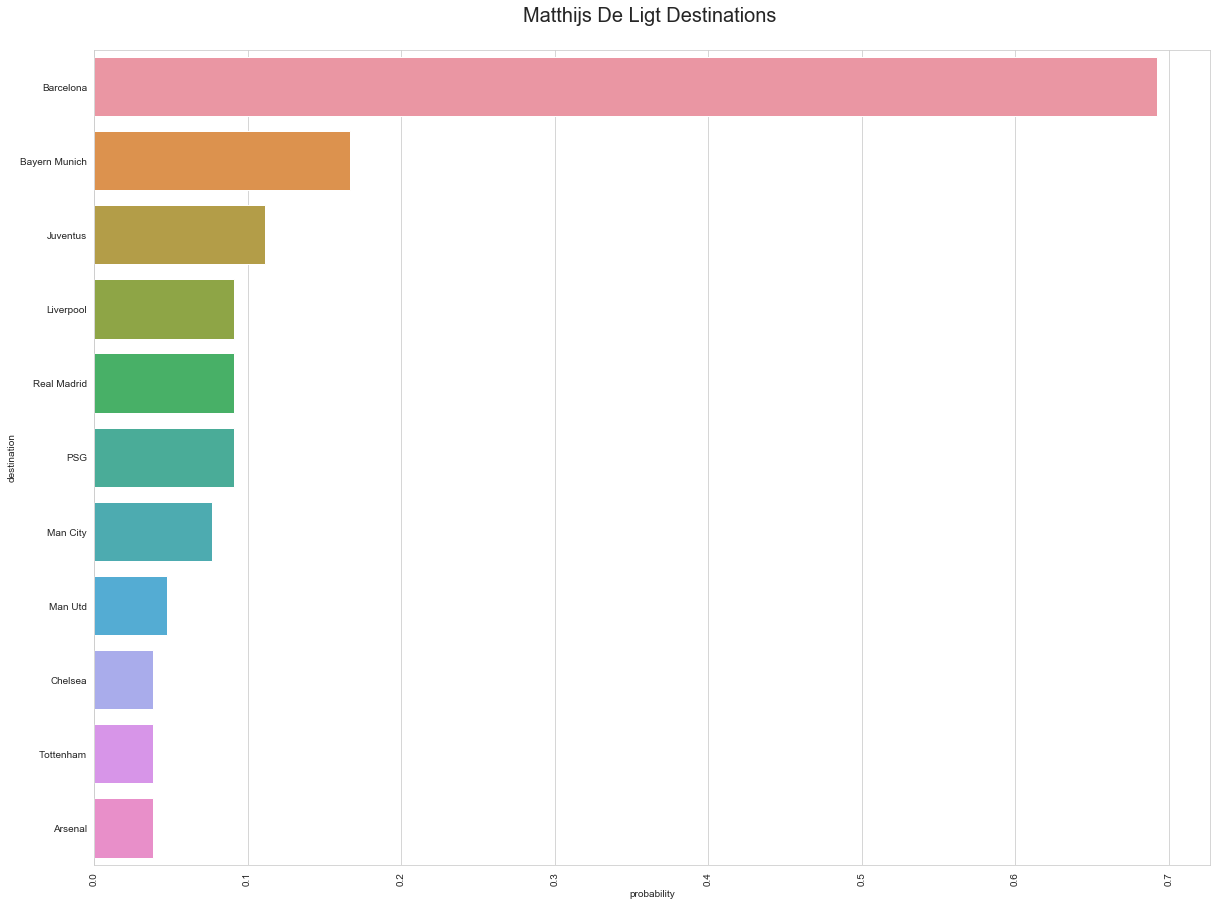

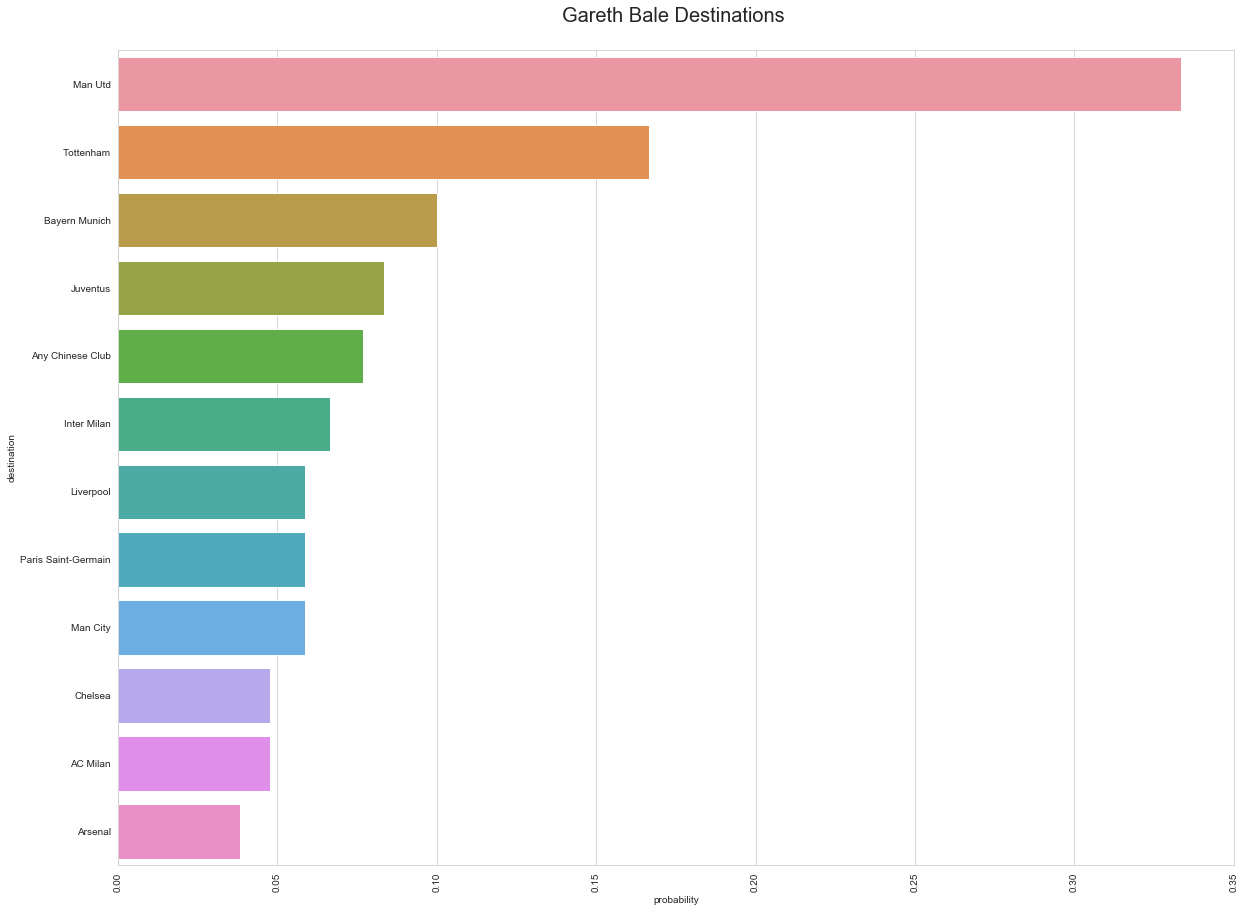

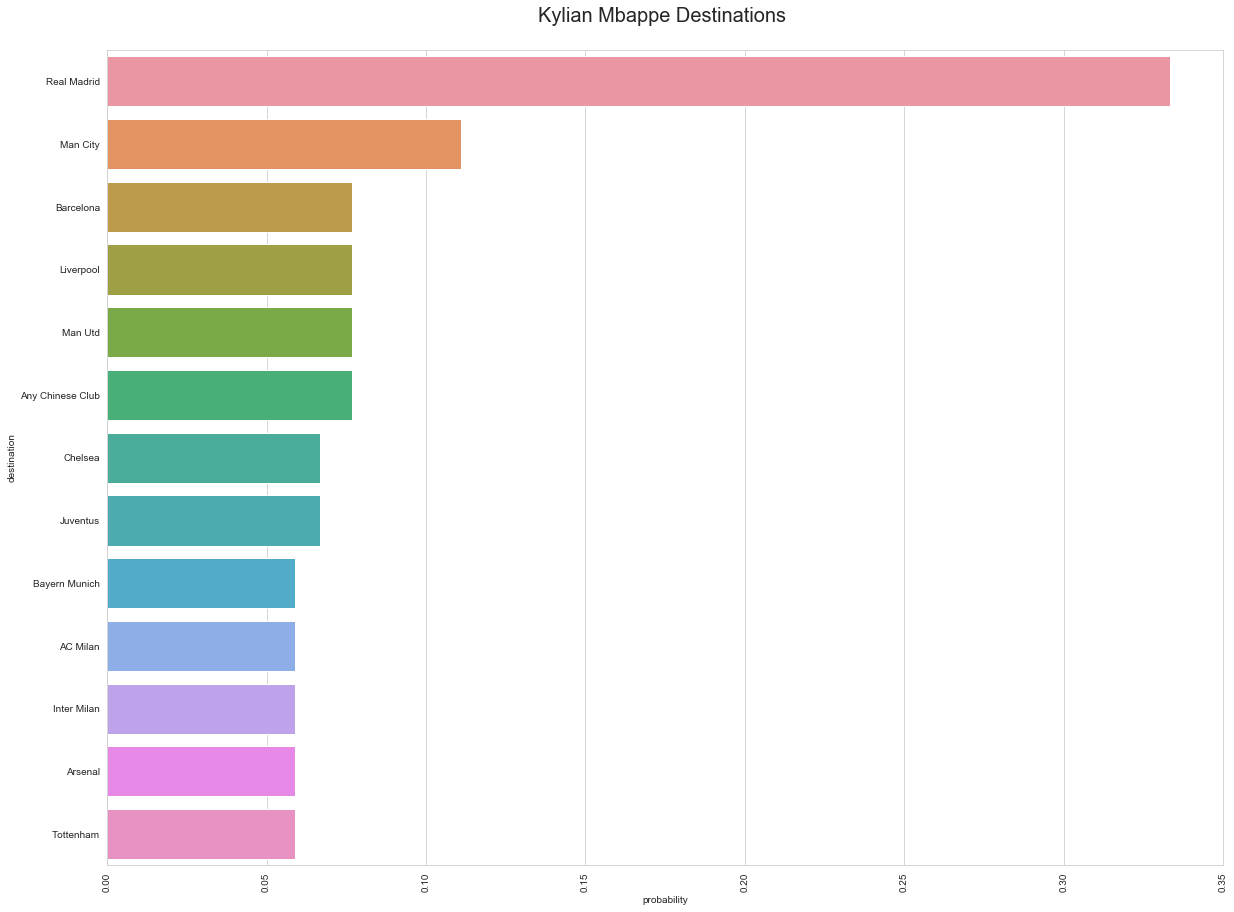

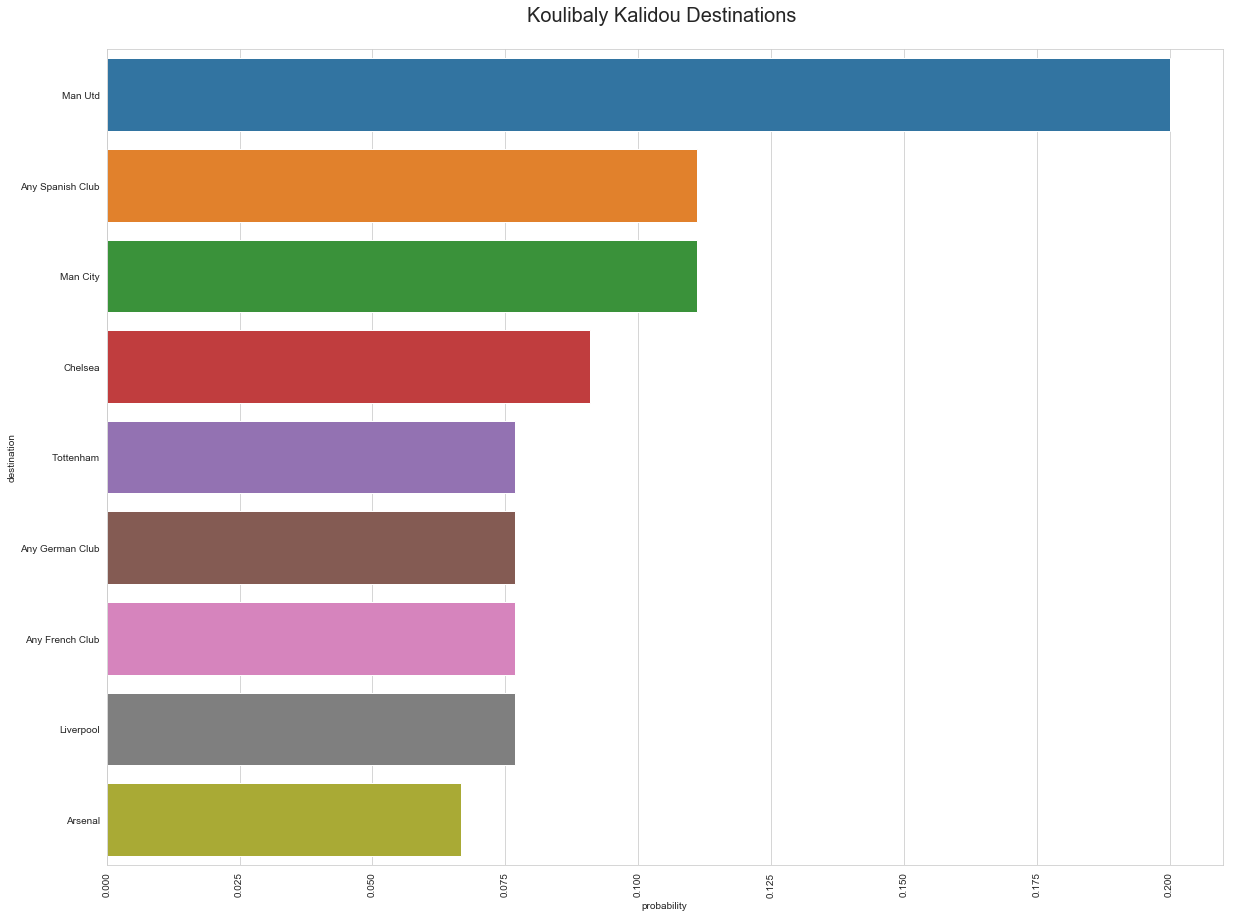

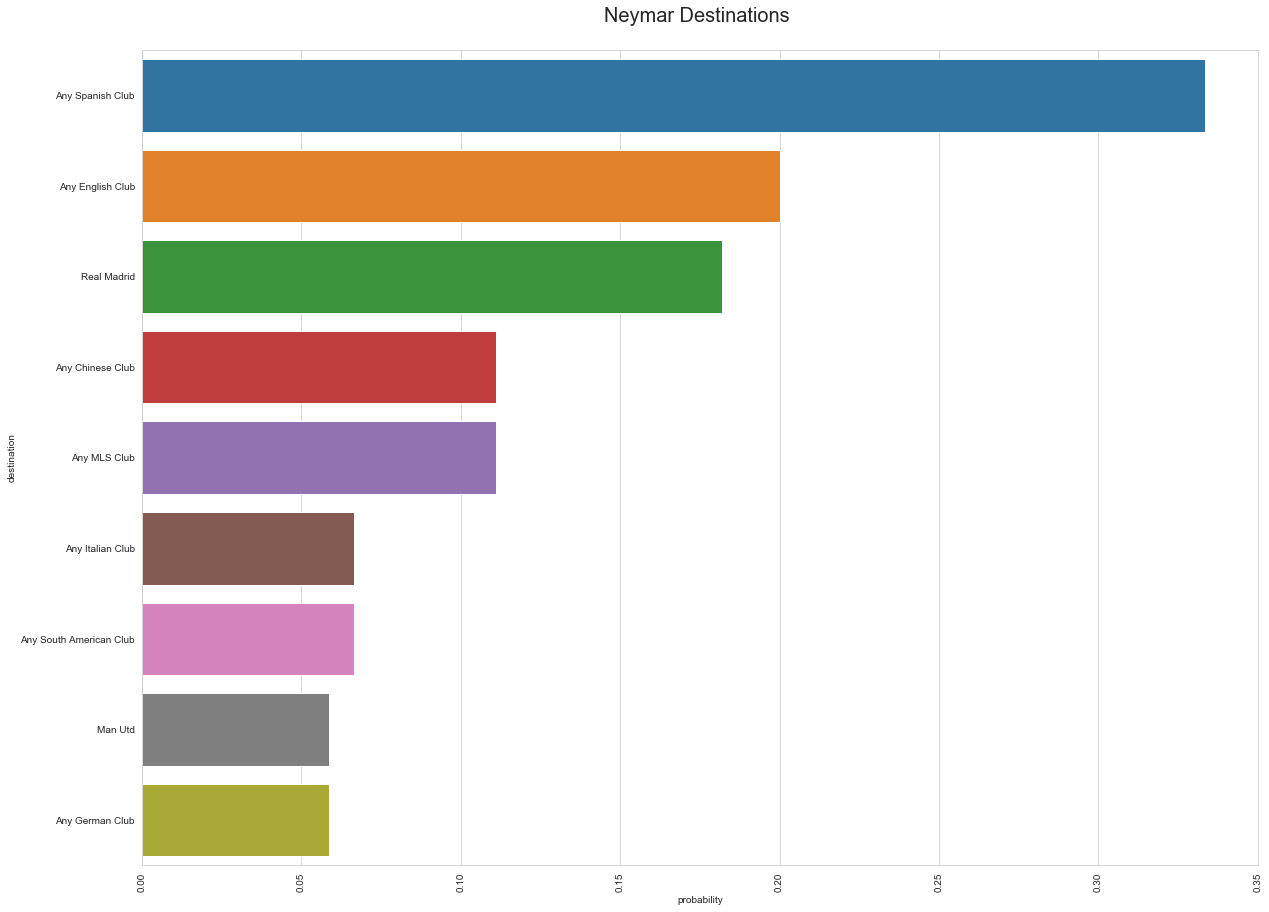

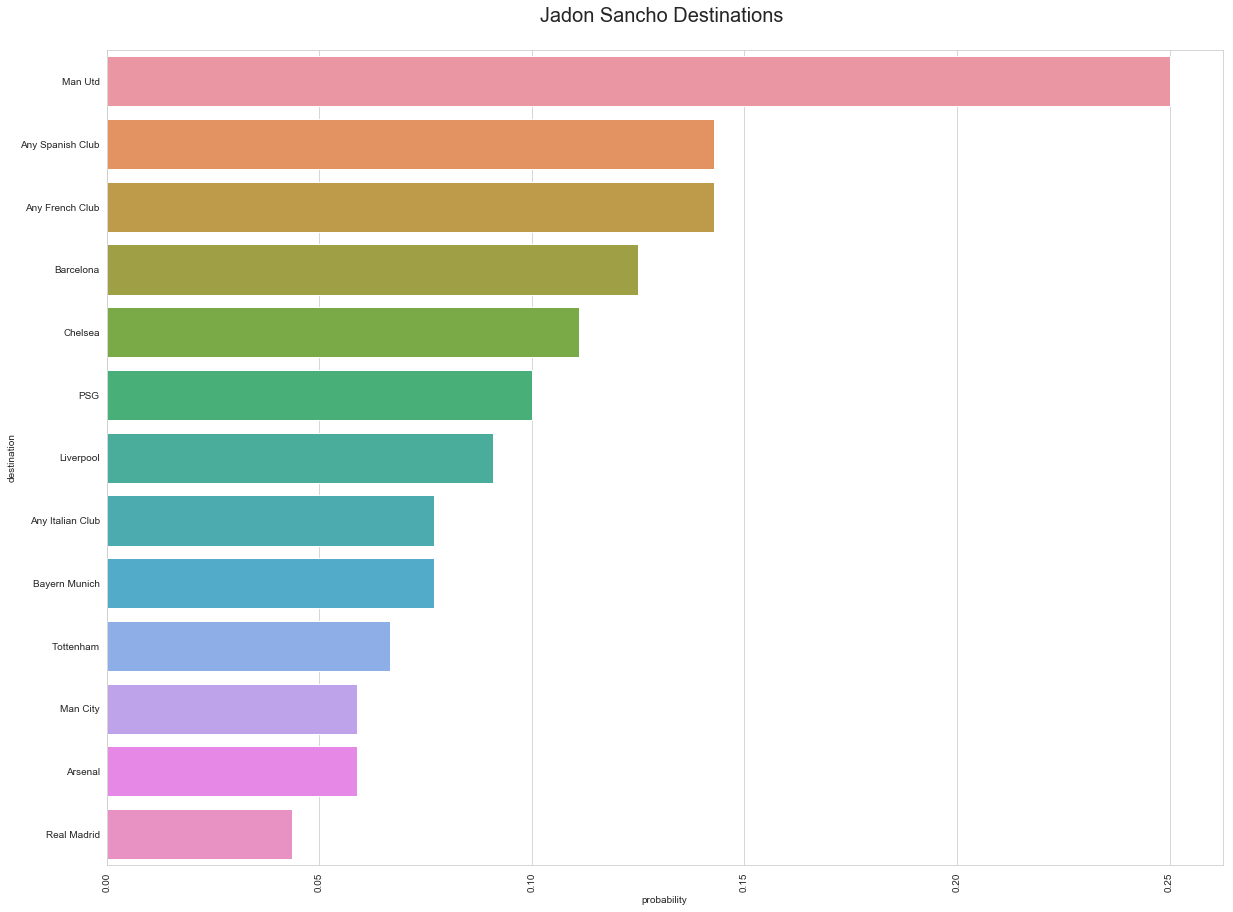

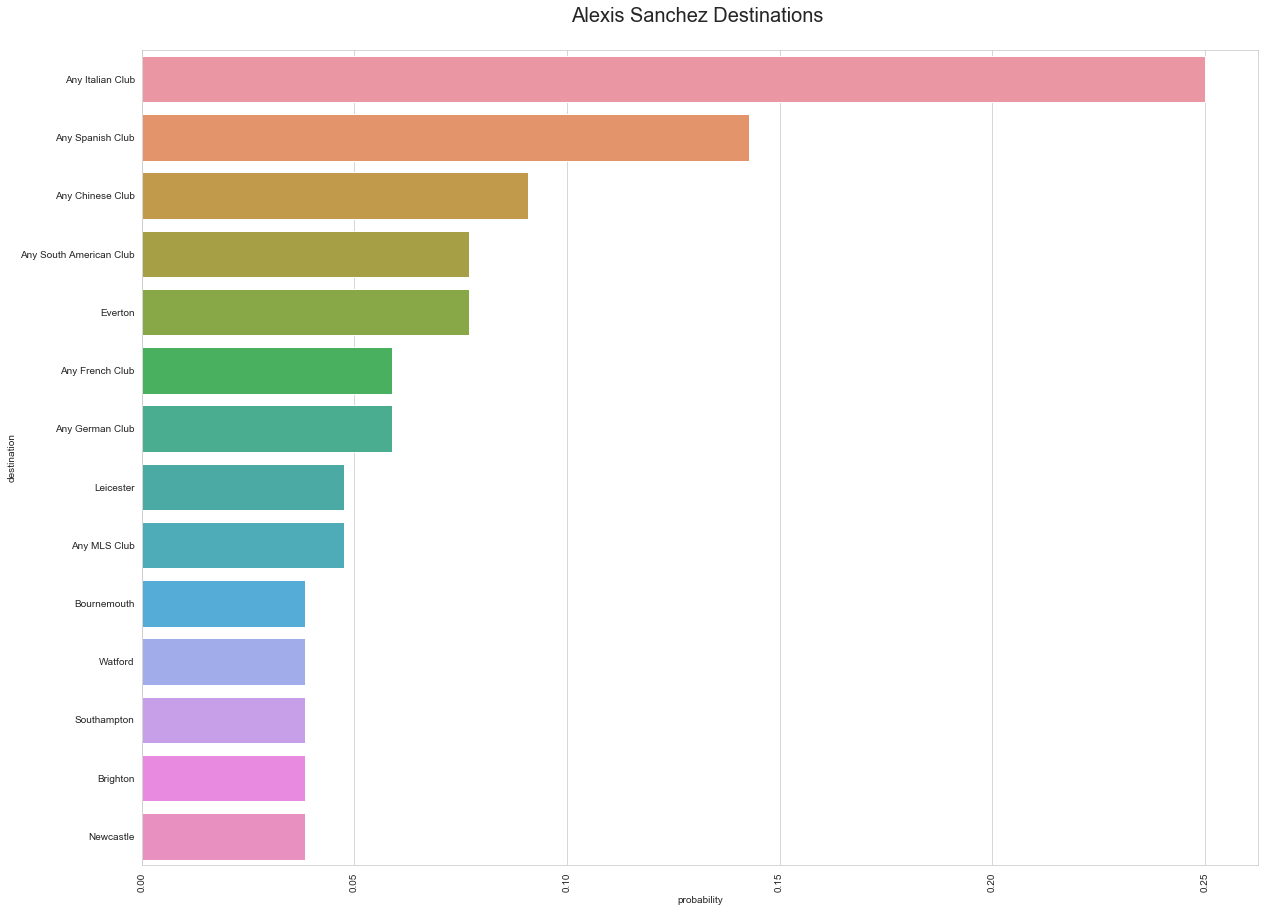

In [68]:
for player in ['Eden Hazard','Adrian Rabiot','David De Gea', 'Matthijs De Ligt','Gareth Bale', 'Kylian Mbappe','Koulibaly Kalidou','Neymar',
              'Jadon Sancho','Alexis Sanchez']:
    get_player_destinations(combined_df,player)

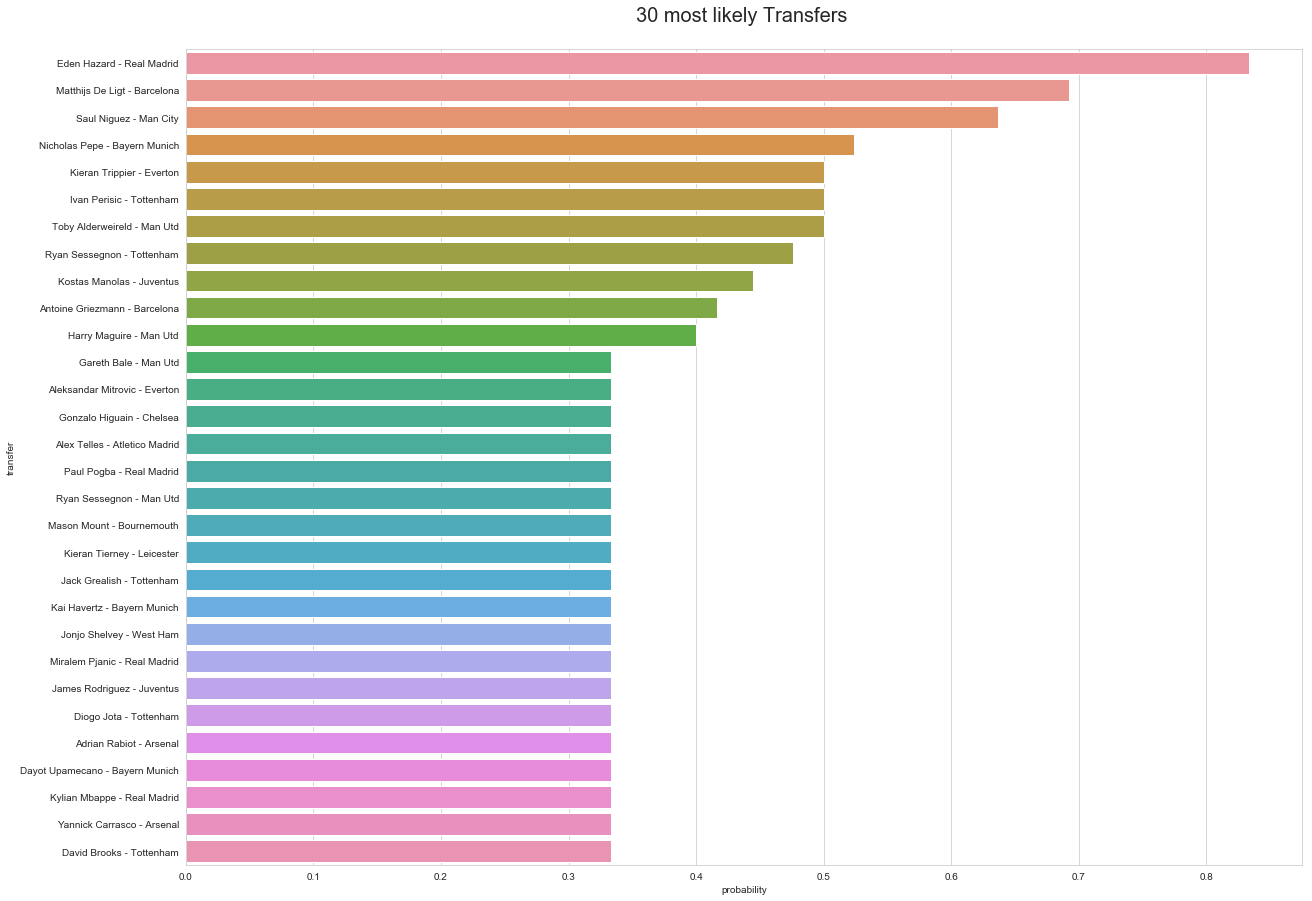

In [69]:
most_likely = combined_df.loc[~combined_df.destination.str.contains('To Stay|To Leave|Any')].sort_values(by='probability',ascending=False).head(30)
most_likely['transfer'] = most_likely.player + ' - ' + most_likely['destination']
plt.subplots(figsize=(20,15))
ax = sns.barplot(data=most_likely,y='transfer',x='probability',orient='h')
ax.set_title('30 most likely Transfers \n',{'fontsize':20})
plt.savefig(f'output/most likely overall.png')